# Predicting Diamond Prices

### Data Set Information:

**A dataset containing the prices and other features of almost 54,000 diamonds.**

### Features description

**Number of Attributes: 10 (9 predictive features, 1 target)**

Feature Information: A data frame with 53,940 rows and 10 variables:

price: price in US dollars (\$326--\$18,823) **(target)**

carat: weight of the diamond (0.2--5.01)

cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)

color: diamond colour, from J (worst) to D (best)

clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

x: length in mm (0--10.74)

y: width in mm (0--58.9)

z: depth in mm (0--31.8)

depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

table: width of top of diamond relative to widest point (43--95)

In [1]:
# Importing useful libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import OrderedDict
%matplotlib inline

In [3]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

## 0. Data Preparation

In [4]:
# importing data
#data_path= '../data/diamonds.csv'
diamonds = pd.read_csv("diamonds.csv")

In [5]:
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.230,Ideal,E,SI2,61.500,55.000,326,3.950,3.980,2.430
1,0.210,Premium,E,SI1,59.800,61.000,326,3.890,3.840,2.310
2,0.230,Good,E,VS1,56.900,65.000,327,4.050,4.070,2.310
3,0.290,Premium,I,VS2,62.400,58.000,334,4.200,4.230,2.630
4,0.310,Good,J,SI2,63.300,58.000,335,4.340,4.350,2.750


In [6]:
diamonds.shape

(53940, 10)

In [7]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [8]:
diamonds.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [9]:
diamonds_corr = diamonds.corr()
diamonds_corr

,carat,depth,table,price,x,y,z
carat,1.000,0.028,0.182,0.922,0.975,0.952,0.953
depth,0.028,1.000,-0.296,-0.011,-0.025,-0.029,0.095
table,0.182,-0.296,1.000,0.127,0.195,0.184,0.151
price,0.922,-0.011,0.127,1.000,0.884,0.865,0.861
x,0.975,-0.025,0.195,0.884,1.000,0.975,0.971
y,0.952,-0.029,0.184,0.865,0.975,1.000,0.952
z,0.953,0.095,0.151,0.861,0.971,0.952,1.000


<AxesSubplot:>

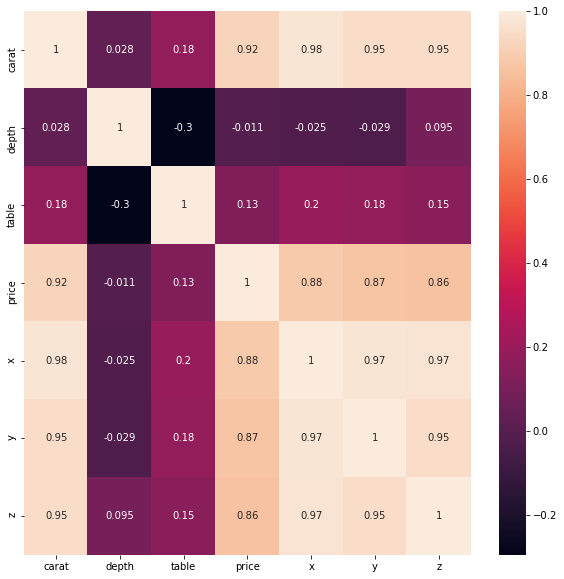

In [14]:
plt.figure(figsize=(10,10))
sns.heatmap(diamonds_corr, annot=True)

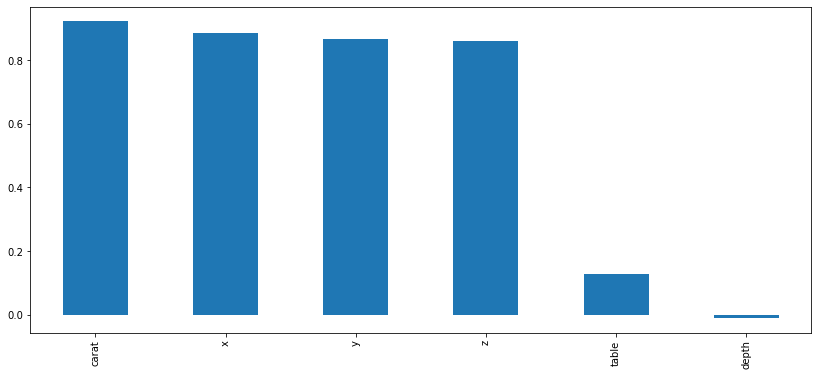

In [15]:
#Correlation of each feature with the Target
corr_with_price = diamonds.corr()["price"].sort_values(ascending=False)
plt.figure(figsize=(14,6))
corr_with_price.drop("price").plot.bar()
plt.show();

One of the transformations we must perform is to tranform the categorical features to the one-hot-encoding format.

In [16]:
print(diamonds['cut'].unique())
print(diamonds['color'].unique())
print(diamonds['clarity'].unique())

['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
['E' 'I' 'J' 'H' 'F' 'G' 'D']
['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']


In [17]:
diamonds['cut'].head()

0      Ideal
1    Premium
2       Good
3    Premium
4       Good
Name: cut, dtype: object

In [18]:
#Apply one hot encoding
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['cut'], prefix='cut', drop_first=True)],axis=1)
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['color'], prefix='color', drop_first=True)],axis=1)
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['clarity'], prefix='clarity', drop_first=True)],axis=1)
diamonds.drop(['cut','color','clarity'], axis=1, inplace=True)

In [19]:
diamonds.head()

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.230,61.500,55.000,326,3.950,3.980,2.430,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0.210,59.800,61.000,326,3.890,3.840,2.310,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0.230,56.900,65.000,327,4.050,4.070,2.310,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.290,62.400,58.000,334,4.200,4.230,2.630,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,0.310,63.300,58.000,335,4.340,4.350,2.750,1,0,0,...,0,0,1,0,0,1,0,0,0,0


In [ ]:
#Check for multicollinearity using Heat Map after one hot encoding.

<AxesSubplot:xlabel='carat', ylabel='price'>

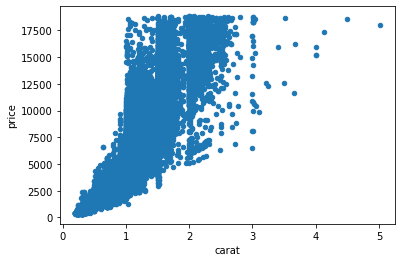

In [20]:
diamonds.plot.scatter(x='carat', y='price')

### Scaling: an important operation

Since the features have different scales (<code>carat</code> goes from 0 to 5, <code>y</code> goes from 0 to 58) we need to be careful. Making sure that each feature has approximately the same scale can be a crucial preprocessing step. In this case we will use the <code>RobustScaler</code> object which scales the features to a common scale and it is robust to outliers.

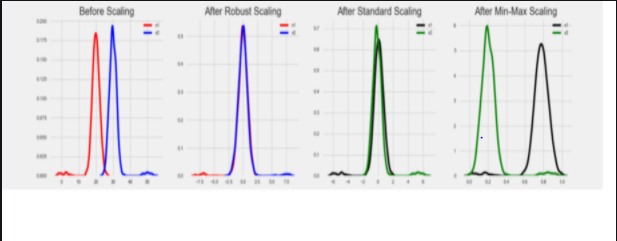

### Getting the train and test sets

In [21]:
#Import important libraries for training,preprocessing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler #another preferable choice is "StandardScaler (works better most times)"

In [63]:
target_name = 'price' #set target giving it a name
robust_scaler = RobustScaler() #prepare the scaler
X = diamonds.drop('price', axis=1) #assign the all features to X variable.
X = robust_scaler.fit_transform(X) #notice we drop away the target before applying scaling. Do not scale the target.
y = diamonds[target_name] #assign the target to y variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123) #do your data splitting

# A. Linear Regression

In [64]:
# 1. Import the estimator object (model)
from sklearn.linear_model import LinearRegression
# 2. Create an instance of the estimator
linear_regression = LinearRegression()
# 3. Use the trainning data to train the estimator
linear_regression.fit(X_train, y_train)

LinearRegression()

In [65]:
#Prediction and Model Evaluation (R-squared,MSE,RMSE,MAE)
y_train_pred1 = linear_regression.predict(X_train) #Train (Already seen this)
y_pred1 = linear_regression.predict(X_test) # Test(New)

print('Train r2 score: ', r2_score(y_train_pred1, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred1))

train_mse1 = mean_squared_error(y_train_pred1, y_train)
test_mse1 = mean_squared_error(y_pred1, y_test)

train_rmse1 = np.sqrt(train_mse1)
test_rmse1 = np.sqrt(test_mse1)
print('Train RMSE: %.2f' % train_rmse1)
print('Test RMSE: %.2f' % test_rmse1)

Train r2 score:  0.9131201324730647
Test r2 score:  0.9186416642686037
Train RMSE: 1128.22
Test RMSE: 1136.68


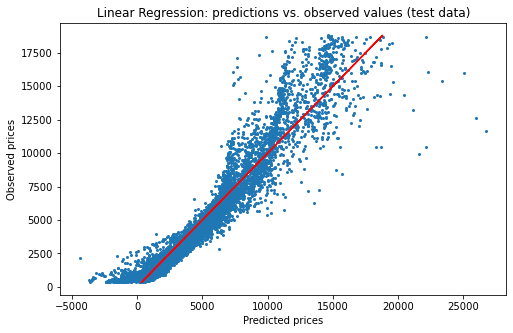

In [66]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(linear_regression.predict(X_test), y_test, s=4)
ax.plot(y_test, y_test, color='red')
ax.set_title('Linear Regression: predictions vs. observed values (test data)')
ax.set_xlabel('Predicted prices')
ax.set_ylabel('Observed prices');

# B. K-Nearest Neighbors Model

In [67]:
# 1. Import the estimator object (model)
from sklearn.neighbors import KNeighborsRegressor
# 2. Create an instance of the estimator
knn = KNeighborsRegressor(n_neighbors=10, weights='distance', metric='euclidean', n_jobs=-1)
# 3. Use the trainning data to train the estimator
knn.fit(X_train, y_train)

KNeighborsRegressor(metric='euclidean', n_jobs=-1, n_neighbors=10,
                    weights='distance')

In [68]:
#Prediction and Model Evaluation
y_train_pred2 = knn.predict(X_train)
y_pred2 = knn.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred2, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred2))
train_mse2 = mean_squared_error(y_train_pred2, y_train)
test_mse2 = mean_squared_error(y_pred2, y_test)
train_rmse2 = np.sqrt(train_mse2)
test_rmse2 = np.sqrt(test_mse2)
print('Train RMSE: %.2f' % train_rmse2)
print('Test RMSE: %.2f' % test_rmse2)

Train r2 score:  0.9999953748088543
Test r2 score:  0.9566332272202814
Train RMSE: 8.58
Test RMSE: 829.88


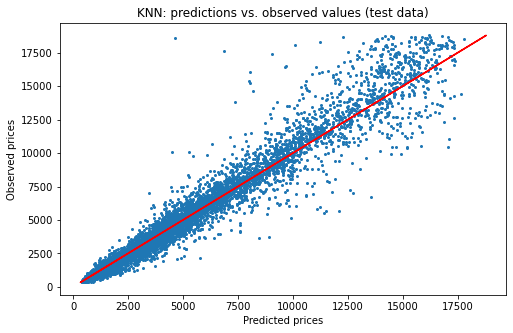

In [69]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(knn.predict(X_test), y_test, s=4)
ax.plot(y_test, y_test, color='red')
ax.set_title('KNN: predictions vs. observed values (test data)')
ax.set_xlabel('Predicted prices')
ax.set_ylabel('Observed prices');

# C. DECISION TREE MODEL

In [70]:
# 1. Import the estimator object (model)
from sklearn.tree import DecisionTreeRegressor
# 2. Create an instance of the estimator
dtree = DecisionTreeRegressor(max_depth=3)
# 3. Use the trainning data to train the estimator
dtree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

In [71]:
y_train_pred3 = dtree.predict(X_train)
y_pred3 = dtree.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred3, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred3))
train_mse3 = mean_squared_error(y_train_pred3, y_train)
test_mse3 = mean_squared_error(y_pred3, y_test)
train_rmse3 = np.sqrt(train_mse3)
test_rmse3 = np.sqrt(test_mse3)
print('Train RMSE: %.2f' % train_rmse3)
print('Test RMSE: %.2f' % test_rmse3)

Train r2 score:  0.8553513796022743
Test r2 score:  0.8745486162701261
Train RMSE: 1418.55
Test RMSE: 1411.48


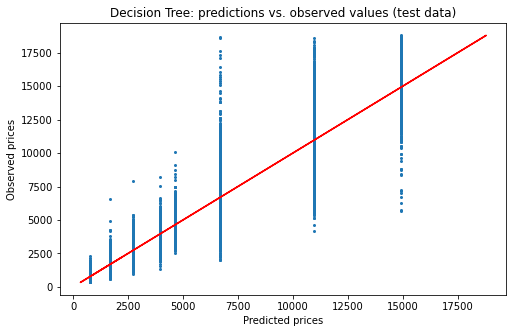

In [72]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(dtree.predict(X_test), y_test, s=4)
ax.plot(y_test, y_test, color='red')
ax.set_title('Decision Tree: predictions vs. observed values (test data)')
ax.set_xlabel('Predicted prices')
ax.set_ylabel('Observed prices');

# D. RANDOM FOREST MODEL

In [73]:
from sklearn.ensemble import RandomForestRegressor
# 1. Import the estimator object (model)
from sklearn.tree import DecisionTreeRegressor
# 2. Create an instance of the estimator
rf = RandomForestRegressor(max_depth=3) #Notice here also we are using here "random forest regressor" not "random forest classifier"
# 3. Use the trainning data to train the estimator
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=3)

In [74]:
y_train_pred4 = rf.predict(X_train)
y_pred4 = rf.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred4, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred4))
train_mse4 = mean_squared_error(y_train_pred4, y_train)
test_mse4 = mean_squared_error(y_pred4, y_test)
train_rmse4 = np.sqrt(train_mse4)
test_rmse4 = np.sqrt(test_mse4)
print('Train RMSE: %.2f' % train_rmse4)
print('Test RMSE: %.2f' % test_rmse4)

Train r2 score:  0.8579148492309591
Test r2 score:  0.8770937031611558
Train RMSE: 1404.04
Test RMSE: 1397.09


# E. XGBOOST 

In [75]:
xgb_model1 = XGBRegressor()
xgb_model1.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=6, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [76]:
y_train_pred5 = xgb_model1.predict(X_train)
y_pred5 = xgb_model1.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred5, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred5))
train_mse5 = mean_squared_error(y_train_pred5, y_train)
test_mse5 = mean_squared_error(y_pred5, y_test)
train_rmse5 = np.sqrt(train_mse5)
test_rmse5 = np.sqrt(test_mse5)
print('Train RMSE: %.2f' % train_rmse5)
print('Test RMSE: %.2f' % test_rmse5)

Train r2 score:  0.9883495369859889
Test r2 score:  0.9781566972592494
Train RMSE: 426.79
Test RMSE: 588.97


# XGBoost Model Hyperparameter Tunning

In [77]:
xgb_model2 = XGBRegressor(n_estimators=1000)
xgb_model2.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=True)
y_train_pred6 = xgb_model2.predict(X_train)
y_pred6 = xgb_model2.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred6, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred6))
train_mse6 = mean_squared_error(y_train_pred6, y_train)
test_mse6 = mean_squared_error(y_pred6, y_test)
train_rmse6 = np.sqrt(train_mse6)
test_rmse6 = np.sqrt(test_mse6)
print('Train RMSE: %.4f' % train_rmse6)
print('Test RMSE: %.4f' % test_rmse6)

[0]	validation_0-rmse:3992.99463
[1]	validation_0-rmse:2894.45361
[2]	validation_0-rmse:2143.69482
[3]	validation_0-rmse:1646.86487
[4]	validation_0-rmse:1321.80005
[5]	validation_0-rmse:1107.45581
[6]	validation_0-rmse:984.69006
[7]	validation_0-rmse:903.40515
[8]	validation_0-rmse:852.51849
[9]	validation_0-rmse:816.98261
[10]	validation_0-rmse:791.29571
[11]	validation_0-rmse:771.33472
[12]	validation_0-rmse:759.30200
[13]	validation_0-rmse:750.90649
[14]	validation_0-rmse:743.73041
[15]	validation_0-rmse:738.43433
[16]	validation_0-rmse:728.37665
[17]	validation_0-rmse:716.31006
[18]	validation_0-rmse:707.71375
[19]	validation_0-rmse:698.11725
[20]	validation_0-rmse:693.82538
[21]	validation_0-rmse:689.63080
[22]	validation_0-rmse:684.40076
[23]	validation_0-rmse:682.91754
[24]	validation_0-rmse:678.87793
[25]	validation_0-rmse:673.24493
[26]	validation_0-rmse:670.10223
[27]	validation_0-rmse:664.99182
[28]	validation_0-rmse:661.33105
[29]	validation_0-rmse:655.90265
[30]	validatio

## Using XGBoost to predict the price of a diamond

If you are happy with your model we can re-train it using all observations, and then use it to make predictions.

In [85]:
# Making predictions
new_diamond = OrderedDict([('carat',0.45), ('depth',62.3), ('table',59.0), ('x',3.95),
                           ('y',3.92), ('z',2.45), ('cut_Good',0.0), ('cut_Ideal',0.0),
                           ('cut_Premium',1.0), ('cut_Very Good',0.0), ('color_E',0.0), 
                           ('color_F',0.0), ('color_G',1.0), ('color_H',0.0), ('color_I',0.0),
                           ('color_J',0.0), ('clarity_IF',0.0), ('clarity_SI1',0.0),
                           ('clarity_SI2',0.0), ('clarity_VS1',0.0), ('clarity_VS2',0.0),
                           ('clarity_VVS1',1.0), ('clarity_VVS2',0.0)])

new_diamond = pd.Series(new_diamond).values.reshape(1,-1)

In [79]:
new_diamond

array([[4.50e-01, 6.23e+01, 5.90e+01, 3.95e+00, 3.92e+00, 2.45e+00,
        0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 5.76e-02]])

In [86]:
xgb_model2.predict(new_diamond) #Use our best model to predict the price of a new daimond coming in just now.

array([6225.922], dtype=float32)